在局部线性嵌入(LLE)原理总结中，我们对流形学习中的局部线性嵌入(LLE)算法做了原理总结。这里我们就对scikit-learn中流形学习的一些算法做一个介绍，并着重对其中LLE算法的使用方法做一个实践上的总结。

# 1. scikit-learn流形学习库概述
　　　　在scikit-learn中，流形学习库在sklearn.manifold包中。里面实现的流形学习算法有：

　　　　1）多维尺度变换MDS算法：这个对应的类是MDS。MDS算法希望在降维时在高维里样本之间的欧式距离关系在低维可以得到保留。由于降维时它需要考虑了样本的全局欧式距离关系，因此降维计算量很大，现在一般较少使用了。

　　　　2）等距映射ISOMAP算法：这个对应的类是Isomap。 ISOMAP算法使用了样本间的测地距离来代替欧式距离，此外基本和MDS算法相同。由于降维时它仍然需要考虑了样本的全局测地距离关系，因此降维计算量很大。

　　　　3）局部线性嵌入LLE算法：这个对应的类是LocallyLinearEmbedding。这个就是我们LLE原理篇里面的算法、除了包含我们原理篇里讲到的标准的LLE实现以外，它还支持改进版的LLE算法，包括MLLE，HLLE和LTSA。这三个算法我们在原理篇的第五节有介绍。后面我们会详细讲这个类的参数使用。

　　　　4）拉普拉斯特征映射LE算法：这个对应的类是SpectralEmbedding。这个算法使用了图论的方法，用样本构成的无向图对应的拉普拉斯矩阵作特征分解来降维。具体方法和我们在谱聚类（spectral clustering）原理总结里面讲到的基本相同。

　　　　5）t-distributed Stochastic Neighbor Embedding（t-SNE）算法:这个对应的类是TSNE。这个是一个比较新的降维方法。t-SNE希望样本间的在高维对应的高斯核函数相似度在低维可以得到保留，即低维和高维有尽量一样的相似度矩阵。

　　　　这些算法基本原理很类似，都基于流形降维后保持样本之间的某一个特定的关系而产生。下面我们重点讲述LLE算法的使用，即LocallyLinearEmbedding的使用。

# 2. LLE算法类库使用介绍
　　　　LLE算法类LocallyLinearEmbedding使用起来并不复杂，一般来说，需要调参的参数只有样本近邻的个数。下面我们对LocallyLinearEmbedding的主要参数做一个介绍。

　　　　1）n_neighbors：即我们搜索样本的近邻的个数，默认是5。 n_neighbors个数越大，则建立样本局部关系的时间会越大，也就意味着算法的复杂度会增加。当然n_neighbors个数越大，则降维后样本的局部关系会保持的更好。在下一节我们可以通过具体的例子看出这一点。一般来说，如果算法运行时间可以接受，我们可以尽量选择一个比较大一些的n_neighbors。

　　　　2）n_components：即我们降维到的维数。如果我们降维的目的是可视化，则一般可以选择2-5维。

　　　　3) reg ：正则化系数，在n_neighbors大于n_components时，即近邻数大于降维的维数时，由于我们的样本权重矩阵不是满秩的，LLE通过正则化来解决这个问题。默认是0.001。一般不用管这个参数。当近邻数远远的大于降维到的维数时可以考虑适当增大这个参数。

　　　　4）eigen_solver：特征分解的方法。有‘arpack’和‘dense’两者算法选择。当然也可以选择'auto'让scikit-learn自己选择一个合适的算法。‘arpack’和‘dense’的主要区别是‘dense’一般适合于非稀疏的矩阵分解。而‘arpack’虽然可以适应稀疏和非稀疏的矩阵分解，但在稀疏矩阵分解时会有更好算法速度。当然由于它使用一些随机思想，所以它的解可能不稳定，一般需要多选几组随机种子来尝试。

　　　　5）method： 即LLE的具体算法。LocallyLinearEmbedding支持4种LLE算法，分别是'standard'对应我们标准的LLE算法，'hessian'对应原理篇讲到的HLLE算法，'modified'对应原理篇讲到的MLLE算法，‘ltsa’对应原理篇讲到的LTSA算法。默认是'standard'。一般来说HLLE/MLLE/LTSA算法在同样的近邻数n_neighbors情况下，运行时间会比标准的LLE长，当然降维的效果会稍微好一些。如果你对降维后的数据局部效果很在意，那么可以考虑使用HLLE/MLLE/LTSA或者增大n_neighbors，否则标准的LLE就可以了。需要注意的是使用MLLE要求n_neighbors > n_components，而使用HLLE要求n_neighbors > n_components * (n_components + 3) / 2

　　　　6）neighbors_algorithm：这个是k近邻的搜索方法，和KNN算法的使用的搜索方法一样。算法一共有三种，第一种是蛮力实现，第二种是KD树实现，第三种是球树实现。这三种方法在K近邻法(KNN)原理小结中都有讲述，如果不熟悉可以去复习下。对于这个参数，一共有4种可选输入，‘brute’对应第一种蛮力实现，‘kd_tree’对应第二种KD树实现，‘ball_tree’对应第三种的球树实现， ‘auto’则会在上面三种算法中做权衡，选择一个拟合最好的最优算法。需要注意的是，如果输入样本特征是稀疏的时候，无论我们选择哪种算法，最后scikit-learn都会去用蛮力实现‘brute’。个人的经验，如果样本少特征也少，使用默认的 ‘auto’就够了。 如果数据量很大或者特征也很多，用"auto"建树时间会很长，效率不高，建议选择KD树实现‘kd_tree’，此时如果发现‘kd_tree’速度比较慢或者已经知道样本分布不是很均匀时，可以尝试用‘ball_tree’。而如果输入样本是稀疏的，无论你选择哪个算法最后实际运行的都是‘brute’。

# 3. LLE用于降维可视化实践
　　　　下面我们用一个具体的例子来使用scikit-learn进行LLE降维并可视化。

　　　　完整代码参见我的github: https://github.com/ljpzzz/machinelearning/blob/master/classic-machine-learning/lle.ipynb

　　　　首先我们载入需要的类库：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import manifold, datasets
from sklearn.utils import check_random_state

我们接着生成随机数据，由于LLE必须要基于流形不能闭合，因此我们生成了一个缺一个口的三维球体。生成数据并可视化的代码如下：

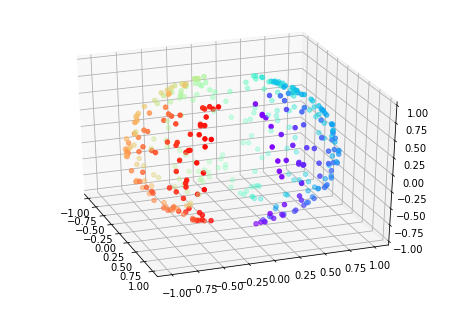

In [2]:
n_samples = 500
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

# 让球体不闭合，符合流形定义
indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
colors = p[indices]
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])

fig = plt.figure()
ax = Axes3D(fig, elev=30, azim=-20)
ax.scatter(x, y, z, c=p[indices], marker='o', cmap=plt.cm.rainbow)

　现在我们简单的尝试用LLE将其从三维降为2维并可视化，近邻数设为30，用标准的LLE算法。

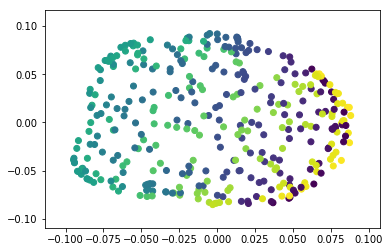

In [3]:
train_data = np.array([x, y, z]).T
trans_data = manifold.LocallyLinearEmbedding(n_neighbors =30, n_components = 2,
                                method='standard').fit_transform(train_data)
plt.scatter(trans_data[:, 0], trans_data[:, 1], marker='o', c=colors)

可以看出从三维降到了2维后，我们大概还是可以看出这是一个球体。

　　　　现在我们看看用不同的近邻数时，LLE算法降维的效果图，代码如下：

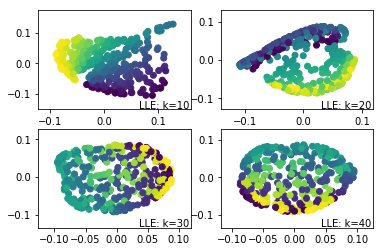

In [4]:
for index, k in enumerate((10,20,30,40)):
    plt.subplot(2,2,index+1)
    trans_data = manifold.LocallyLinearEmbedding(n_neighbors = k, n_components = 2,
                                method='standard').fit_transform(train_data)
    plt.scatter(trans_data[:, 0], trans_data[:, 1], marker='o', c=colors)
    plt.text(.99, .01, ('LLE: k=%d' % (k)),
                 transform=plt.gca().transAxes, size=10,
                 horizontalalignment='right')
plt.show()

现在我们看看还是这些k近邻数，用HLLE的效果。

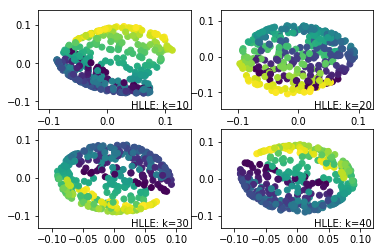

In [5]:
for index, k in enumerate((10,20,30,40)):
    plt.subplot(2,2,index+1)
    trans_data = manifold.LocallyLinearEmbedding(n_neighbors = k, n_components = 2,
                                method='hessian').fit_transform(train_data)
    plt.scatter(trans_data[:, 0], trans_data[:, 1], marker='o', c=colors)
    plt.text(.99, .01, ('HLLE: k=%d' % (k)),
                 transform=plt.gca().transAxes, size=10,
                 horizontalalignment='right')
plt.show()

可见在同样的近邻数的时候，HLLE降维后的数据分布特征效果要比LLE更好。